# Elastic FWI without low-frequencies

Here, we initialize the elastic full-waveform inversion in a setup identical to the field data experiment and run it on Marmousi II benchmark model.

------
This notebook reproduces the workflow for generation of synthetic data from from 
**"Multi-task learning for low-frequency extrapolation and elastic model building from seismic data"**

by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/), [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Daniel Peter](https://github.com/danielpeter), KAUST, Saudi Arabia, 2021

In [41]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize

import utils.shared as sd
from utils.shared import Survey
import utils.loaders as ld
import utils.vis as vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/ovcharoo/work/env_torch


In [42]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [43]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [44]:
root_fwi = './pretrained_files/fwi_outputs/out_fwi_marm_nolow/'

# Init Denise API

In [45]:
denise_root = './DENISE-Black-Edition-master/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/multilow
Init paths at ./outputs/


In [46]:
# d.parser_report()

## Work directory
Where to output everything

In [47]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/ovcharoo/work/multilow
Init paths at ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/


# Get acquitision details

In [48]:
survey = sd.load_obj('./pretrained_files/data/survey.pkl')

src = survey.src
rec = survey.rec
vp = survey.vp
dx = survey.dx
wb_taper = survey.wb_taper
log_idx = survey.log_idx
bpw = survey.bpw
log_loc = survey.log_loc
dDT = survey.dDT
dNT = survey.dNT

Load obj from ./pretrained_files/data/survey.pkl


In [49]:
dsrc = np.mean(src.x[1:] - src.x[:-1])
print('Field data spacing between sources {:.2f} m'.format(dsrc))

Field data spacing between sources 150.00 m


In [50]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')

def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

def get_vp_vs_rho(vp):
    # Some model tuning
    # Add water
    vp = extend(vp, 15, 0)
    print(f'Reshape {vp.shape} into {wb_taper.shape}...')
    
    # Resize end extend
    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # Gardner's relation
    # https://www.subsurfwiki.org/wiki/Gardner%27s_equation
    # Density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    
    # Shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    return vp, vs, rho

(152, 600)
./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/


### Re-scale to field survey dimensions

In [51]:
vp_marm = ld.load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
print(vp_marm.min(), vp_marm.max())

# This is what was used in generation of training data
box_min = 1490.
box_max = 4000. 

vmin_marm = vp_marm.min()
vp_marm -= vmin_marm

vmax_marm = vp_marm.max()
vp_marm /= vmax_marm
vp_marm = box_min  + vp_marm * (box_max - box_min)
print(vp_marm.min(), vp_marm.max())

(174, 500)
1500.0 4766.604
1490.0 4000.0


### Make vs, rho from vp

Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


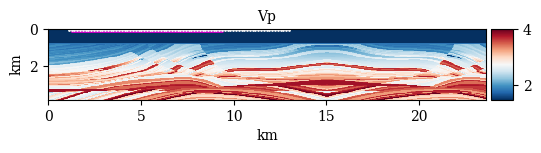

In [52]:
vp, vs, rho = get_vp_vs_rho(vp_marm)
vis.plot_acquisition(vp, dx, src, rec, title='Vp')
model = api.Model(vp, vs, rho, dx)
print(model)

### Good initial model
This one is available together with the true model in DENISE-Black-Edition repository. We do not use it in inversion but rather have it as a reference.

**NOT USED**

(174, 500)
Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


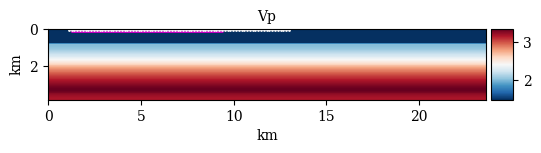

In [53]:
vp_marm_linear = ld.load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]
vp_marm_linear -= vmin_marm
vp_marm_linear /= vmax_marm
vp_marm_linear = box_min  + vp_marm_linear * (box_max - box_min)

vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
vis.plot_acquisition(vp_linear, dx, src, rec, title='Vp')
model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)

log_linear = vp_linear[:, log_idx]
print(model)

## Acquisition design

vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


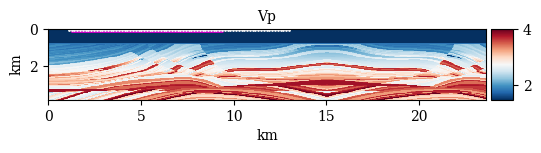

In [54]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :dNT]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

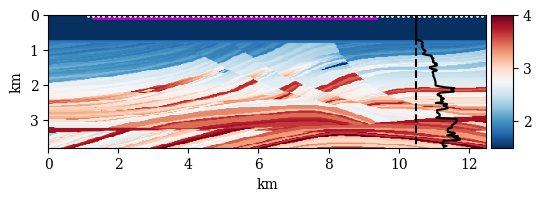

In [55]:
# Well-log location
log_loc = 10500
log = model.vp[:, log_idx]

log_dict = {'data':log/2, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)

In [56]:
wb_taper = model.vp < 1.01 * model.vp.min()
print(wb_taper.shape, model.vp.shape, vp_linear.shape)

(152, 944) (152, 944) (152, 944)


(152, 944)


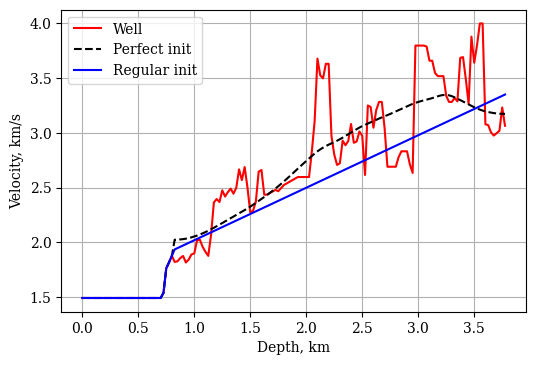

In [57]:
vp_new = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = box_min * np.ones_like(vp_new[:, 0:1])
    fun[wb:, :] = 420 + fun[wb:, :] + 12 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
vp_new = np.concatenate(vps, -1)

# Assume known water bottom and shallow sediments
# This assumption is not used in experiment with predicted data
ids, ide = -33, None
vp_new[ids:ide, :] = vp_linear[ids:ide, :]

print(vp_new.shape)
log_new = vp_new[-len(log):, log_idx]

fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(log)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'r', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Perfect init')
ax.plot(ax_depth, log_new[::-1] / 1000, 'b', label='Regular init')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend();

Create initial **from regular initial model** (blue in the chart above)

In [58]:
# shear velocity, [m/s]
vs_new = vp_new.copy() / (3 ** 0.5)
vs_new = np.where(vp_new < 1.01 * np.min(vp_new), 0, vs_new)

# density, [kg/m3] 
rho_new = 1e3*0.3 * vp_new.copy()**0.25
rho_new = np.where(vp_new < 1.01 * np.min(vp_new), 1000, rho_new)

In [59]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [60]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = dNT
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [61]:
print(f'Found {multiprocessing.cpu_count()} cores in your machine. Manually set "num_parallel_shots" below')

Found 56 cores in your machine. Manually set "num_parallel_shots" below


In [62]:
d.NPROCX = 1
d.NPROCY = 1

# Edit the line below to match your machine specs
num_parallel_shots = 4# 40

par_forward = {'run_command': f'mpirun -np {num_parallel_shots}', 'disable': False}

In [64]:
if not os.listdir(d._root_su):
    print(f'Create {d.save_folder} and run forward modeling...')
    d.forward(model, src, rec, **par_forward)
else:
    print(f'Synthetic seismic data already exists in {d._root_su}')

Create ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/ and run forward modeling...
Current directory is /home/ovcharoo/work/multilow
Init paths at ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 871.7581001035492 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.44995230464552 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.vp
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.vs
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.rho
Enable streamer mode!
	source 1: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/receiver/receivers_shot_1
	source 2: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/receiver/receivers_shot_2
	source 3: ./pretrained_files/fwi_

Read 80 shots (324, 3000) into list


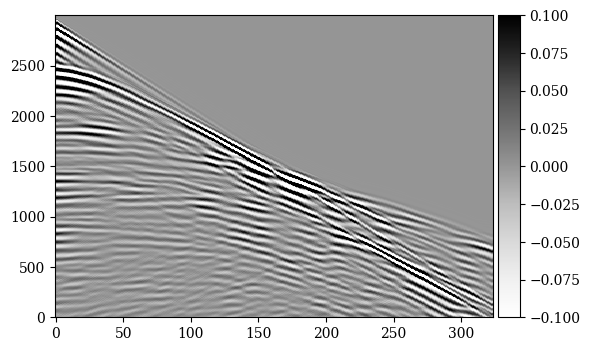

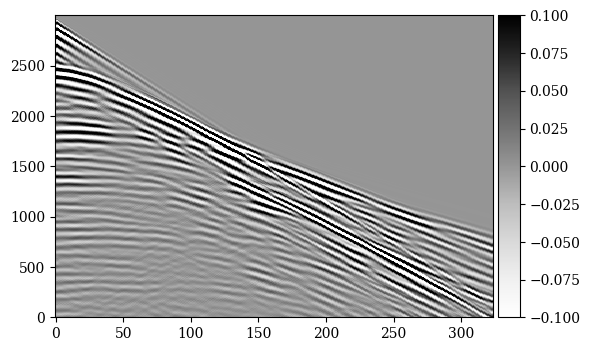

In [65]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p.'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 2)]:
        try:
            shot_s = ld.divmax(shots[i])
            vis.plot_shot(shot_s, pclip=0.1)
        except Exception as e:
            print(f'Failed to fetch data for i={i}. {e}')

# Sources

Total sources: 80
Syn wavelets:	(80, 500)	-250.17	344.49
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


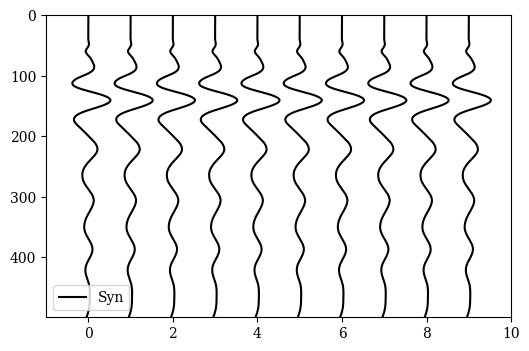

In [66]:
wavelets_s = []
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
print(f'Total sources: {len(wavelets_s)}')
wavelets_s = np.concatenate(wavelets_s, 0)
print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
vis.plot_wiggles(wavelets_s, n=10, colors=['k'], legend=['Syn'])

In [67]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
nx0 = 500
nz0 = model.vp.shape[0]
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vs = {'vmin': model.vs.min() / 1000, 'vmax': model.vs.max() / 1000}
limits_rho = {'vmin': model.rho.min() / 1000, 'vmax': model.rho.max() / 1000}

## Initial model

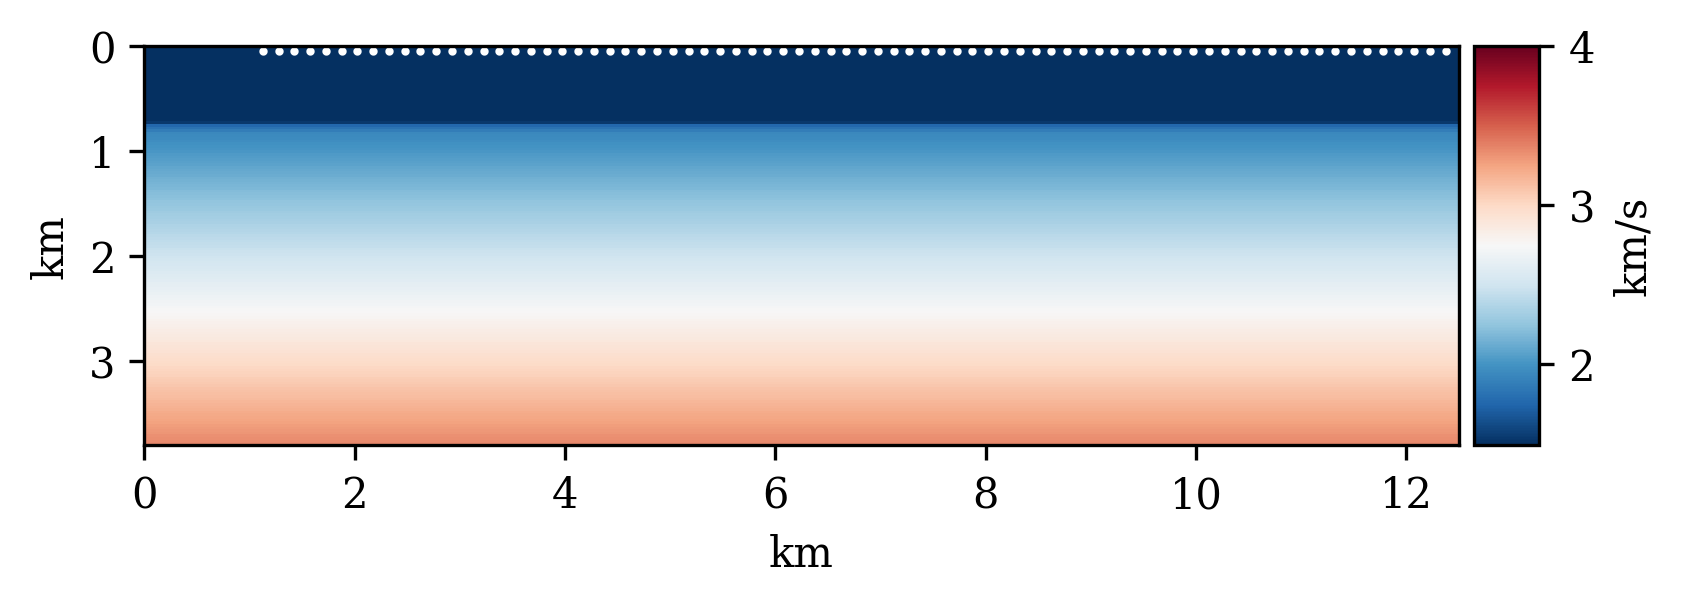

In [68]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(vp_new, dx, nx0, nz0, src, **limits_vp)
mpl.rcParams['figure.dpi']= 100

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

In [69]:
xcut = 672
wb_taper = wb_taper[:, :xcut]
model_init = api.Model(vp_new[:, :xcut], vs_new[:, :xcut], rho_new[:, :xcut], dx)
print(model_init)

vp:	(152, 672), 1490.0000, 3350.0000 m/s

vs:	(152, 672), 0.0000, 1934.1234 m/s

rho:	(152, 672), 1000.0000, 2282.3511 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 16775.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

152 (152, 672) 152


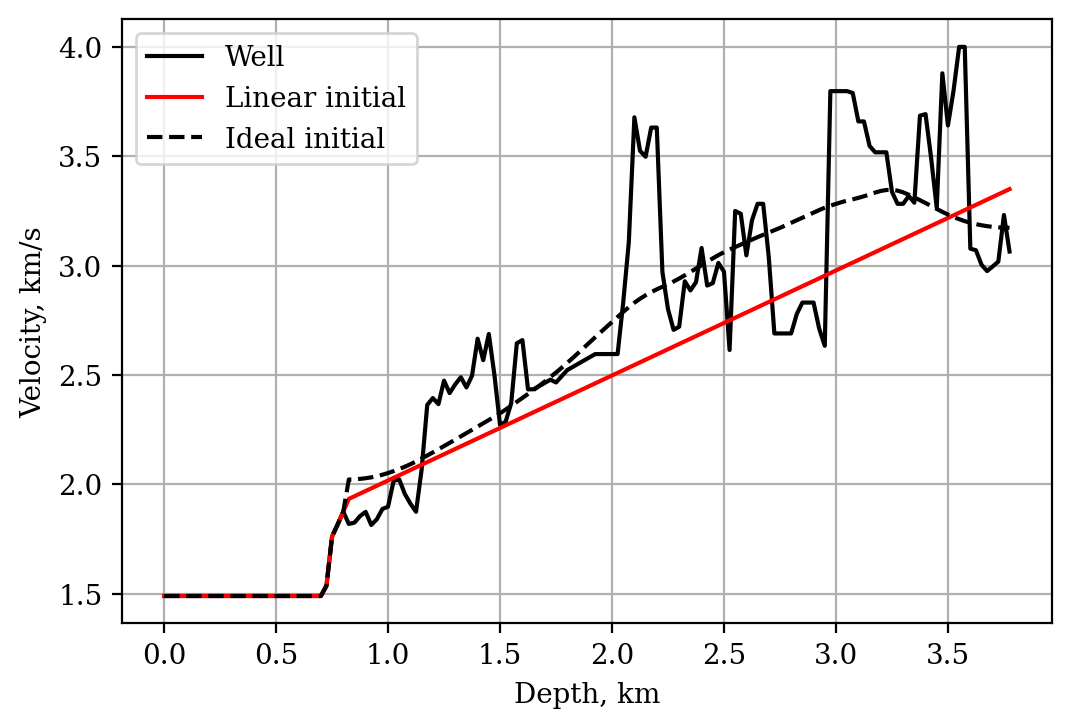

In [70]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

mpl.rcParams['figure.dpi']= 200
fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well')
log_bad = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_bad[::-1] / 1000, 'r', label='Linear initial')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Ideal initial')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()
mpl.rcParams['figure.dpi']= 100
print(len(log), model_init.vp.shape, len(model_init.vp[:len(log)]))

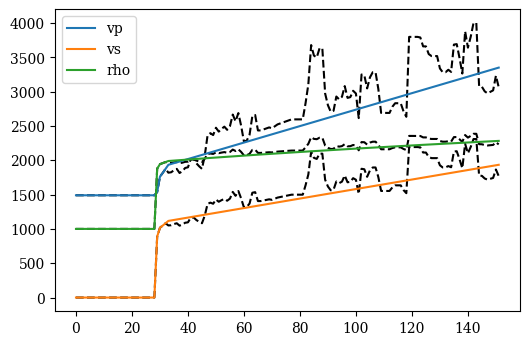

In [71]:
vis.plot_logs(model, model_init, log_idx)

## Stages of inversion

In [72]:
par_stages_fwi = {'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'spatfilter': 4,
                 'order': 6,
                 }

d.fwi_stages = []
d.add_fwi_stage(fc_low=5, fc_high=8, 
                wd_damp=2,
                wd_damp1=2,
                **par_stages_fwi)
print(f'Stage {i+1}:\n\t{d.fwi_stages[0]}\n')

Stage 80:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 5, 'FC_HIGH': 8, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 2, 'WD_DAMP1': 2, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}



In [73]:
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30

(152, 672) (152, 672)
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/taper/taper.bin
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/taper/taper_u.bin
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/taper/taper_rho.bin


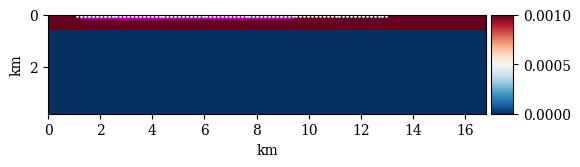

In [74]:
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

# Box conditions for FWI
d.VPUPPERLIM = 4000.
d.VPLOWERLIM = 1490.
d.VSUPPERLIM = 2500.
d.VSLOWERLIM = 0.
d.RHOUPPERLIM = 2500.
d.RHOLOWERLIM = 1000.

d.SWS_TAPER_FILE = 1

taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
taper[shift:, :] = wb_taper[:-shift,:] # water mask

if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

## Run inversion

In [75]:
print(f'Target data: {d.DATA_DIR}')

Target data: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/su/seis


In [76]:
d.WRITE_STF = 0
d.NPROCX = 8
d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}

In [77]:
d.fwi(model_init, src, rec, **par_fwi_runtime)

Target data: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/su/seis
Create FWI workflow file in ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/seis_fwi.inp
Init model:
	152 x 672, dx = 25.0 m
Check max source frequency:
	min Vs: 887.3093330554276 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.618529355614392 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 672 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.vp
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.vs
Write ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/receiver/receivers_shot_1
	source 2: ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/receiver/receivers_shot

### Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [78]:
d.set_model(model_init)
d.set_paths()

Init model:
	152 x 672, dx = 25.0 m
Current directory is /home/ovcharoo/work/multilow
Init paths at ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/


### Inverted model from linear initial
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

Parse files from ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model which contain ['vp', 'stage']
Found 1, e.g. ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model/modelTest_vp_stage_1.bin


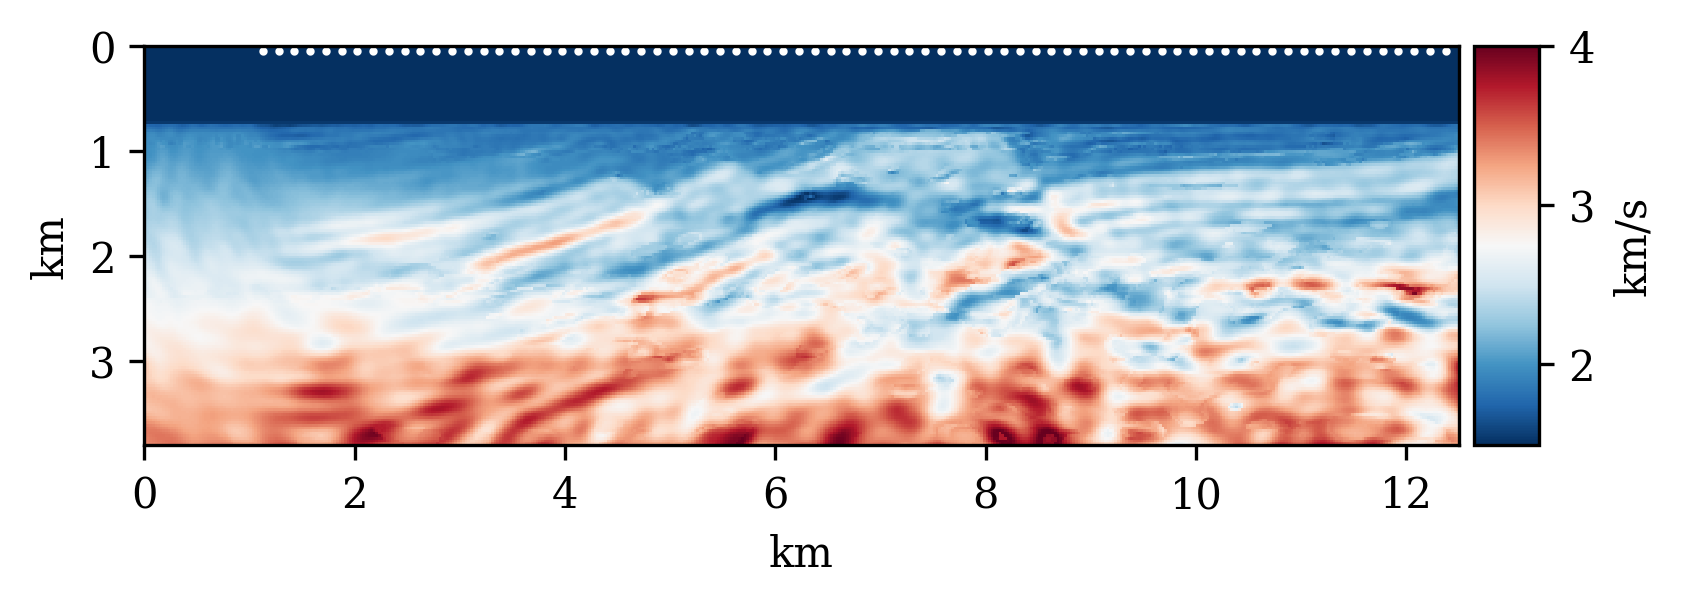

In [79]:
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, **limits_vp)
mpl.rcParams['figure.dpi']= 100

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

Parse files from ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model which contain ['vp_stage']
Found 1, e.g. ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model/modelTest_vp_stage_1.bin
Parse files from ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model which contain ['vs_stage']
Found 1, e.g. ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model/modelTest_vs_stage_1.bin
Parse files from ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model which contain ['rho_stage']
Found 1, e.g. ./pretrained_files/fwi_outputs/out_fwi_marm_nolow/model/modelTest_rho_stage_1.bin


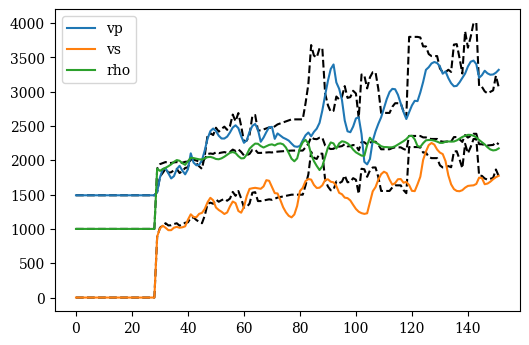

In [80]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    vis.plot_logs(model, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [40]:
# d.verbose = 0
# grads, fnames = d.get_fwi_gradients(return_filenames=True)
# for g, f in zip(grads, fnames):
#     plot_model(g, f)

In [346]:
# d.help()